# Fruit and Vegetable Classification
##  Grad-CAM class activation visualization

Having 3861 images of 36 different fruits/vegetables

![fruit vegetable](https://i.imgur.com/KUAcIQD.jpeg)


# **Motivation**
Accurate identification of fruits and vegetables is essential across multiple domains of our modern food systems. From agricultural supply chains to retail environments, dietary tracking applications to quality control in processing facilities, the need for automated and reliable classification of produce is increasingly critical. Traditional manual identification methods are time-consuming, subjective, and prone to human error, especially when dealing with thousands of items daily in commercial settings. Furthermore, in smart agriculture systems, the ability to accurately identify and classify produce enables precision sorting, reduces food waste, and improves inventory management. Deep learning approaches like our CNN-based classifier offer a scalable solution to this challenge by leveraging visual patterns that distinguish different fruits and vegetables. This technology can empower consumers to make informed nutritional choices, help retailers optimize produce management, assist in educational contexts, and ultimately contribute to more efficient and sustainable food systems in an era when maximizing resource utilization has never been more important.

# 📘 **Setup: Key Libraries**

This cell imports essential libraries for data analysis, visualization, and deep learning. Here's a quick overview:
This foundational setup supports preprocessing, model development, and performance evaluation efficiently.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


# 📂 **Data Preparation**
This dataset contains images of the following food items:

fruits: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
vegetables: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

#Content
This dataset contains three folders:

train (100 images each)
test (10 images each)
validation (10 images each) each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present



### **Steps**:
1. **Dataset Paths**:  
   - Training images: `C:/Data Sets/Train/`
   - Testing images: `C:/Data Sets/Test/`
   - Validation images: `C:/Data Sets/Validation/`


2. **Process**:  
   - Create a list with the filepaths for training and testing
   - Create a DataFrame with the filepath and the labels of the pictures  
   - Concatenate filepaths and labels  
   - Shuffle the DataFrame and reset index.  
3. **Output**:  
   - `train_df`: lablled dataframe for training data.  
   - `test_df`: labelled dataframe for testing data.  
   - `validation_df`: labelled dataframe for validation data.

In [6]:
from pathlib import Path
import pandas as pd

# Create a list with the filepaths for training and testing
train_dir = Path(r"C:\Data Sets\Train")  # Use raw string
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(r"C:\Data Sets\Test") # Use raw string
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(r"C:\Data Sets\Validation") # Use raw string
val_filepaths = list(val_dir.glob(r'**/*.jpg')) # Use val_dir instead of test_dir

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] #Use backslash when splitting
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3278

Number of different labels: 36

Labels: ['sweetpotato' 'sweetcorn' 'paprika' 'spinach' 'onion' 'soy beans'
 'garlic' 'eggplant' 'ginger' 'orange' 'capsicum' 'tomato' 'bell pepper'
 'kiwi' 'turnip' 'chilli pepper' 'raddish' 'cauliflower' 'apple' 'banana'
 'potato' 'pear' 'corn' 'cabbage' 'beetroot' 'watermelon' 'lettuce'
 'carrot' 'mango' 'jalepeno' 'pineapple' 'grapes' 'peas' 'pomegranate'
 'cucumber' 'lemon']


# 🖼️ **Visualizing Unique Samples from Each Category**

This code displays one sample image for each label category, providing an overview of the dataset's contents.

### **Steps**:

1. **Prepare Unique Samples**:  
   - Create a DataFrame containing one example per label by removing duplicates based on the **`Label`** column and resetting the index.

2. **Setup and Display Images**:  
   - Create a **6x6 grid** of subplots with a figure size of **8x7**.  
   - For each unique label, display its corresponding image with the label as the title.  
   - Adjust the layout for a tidy presentation.

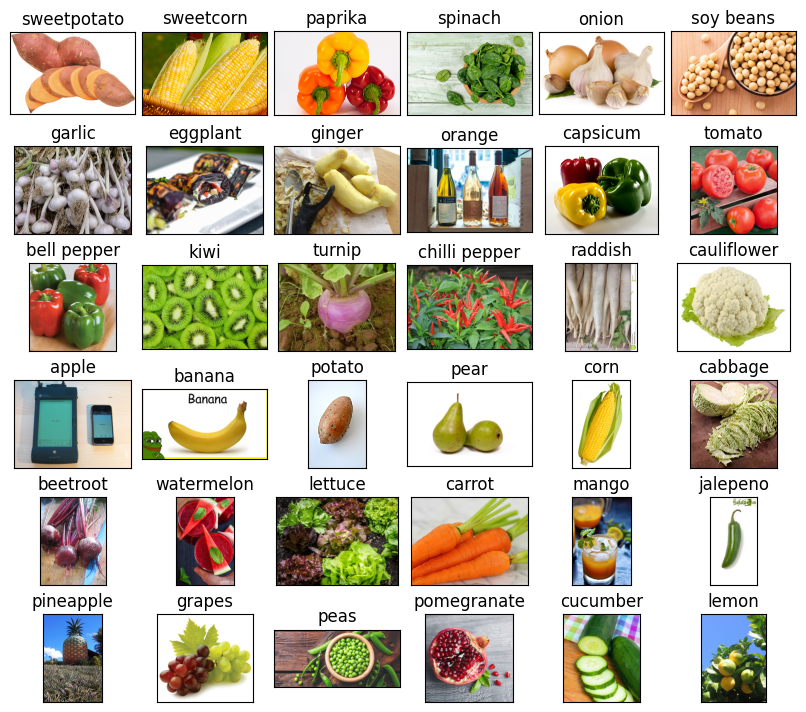

In [8]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

#  Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a>

The data augmentation techniques implemented in this notebook are carefully selected to simulate real-world variability in fruit and vegetable appearances. Each transformation addresses specific challenges in produce classification:
* Rotation (30°): Fruits and vegetables may be presented at different angles in real-world scenarios, whether on store shelves, in sorting facilities, or in consumer photos. This rotation range ensures the model is orientation-invariant.
* Zoom (±15%): This simulates varying distances between the camera and produce, helping the model generalize across different image capture conditions and produce sizes.
* Width/Height Shifts (20%): These transformations account for off-center positioning of items, particularly important in automated sorting systems where perfect centering isn't guaranteed.
* Shear (15%): Applies perspective-like transformations that help the model recognize produce when viewed from slightly different angles or when placed on irregular surfaces.
* Horizontal Flip: Creates mirror images of produce, addressing the arbitrary orientation of fruits and vegetables in natural settings. This is especially valuable for asymmetric items like bananas or eggplants.

These augmentations collectively expand our training dataset, reduce overfitting, and create a more robust model capable of generalizing across the natural variations found in real-world produce.

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3278 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


In [10]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# 🍎 **Deep Learning for Fruit and Vegetable Classification Using CNN**

### **Theory of Convolutional Neural Networks (CNNs)**:

Convolutional Neural Networks (CNNs) are widely used in image classification tasks, making them ideal for classifying fruits and vegetables. These models automatically learn spatial patterns, textures, and shapes in images, enabling accurate predictions without manual feature extraction.

#### **Key Components of CNNs**:

1. **Convolutional Layer**:  
   - Extracts features like edges, textures, and shapes by applying filters to the input image.  
   - Scans images through small patches, creating feature maps representing the presence of specific patterns.

2. **Activation Function**:  
   - Adds non-linearity to the model using **ReLU (Rectified Linear Unit)**, enabling it to learn complex relationships in the data.

3. **Pooling Layer**:  
   - Reduces the spatial dimensions of feature maps through operations like max pooling, retaining essential information while decreasing computational complexity.  
   - Helps the model become invariant to minor changes in the input.

4. **Fully Connected Layer**:  
   - Integrates high-level features extracted by convolutional layers to make final predictions.  
   - Dense layers aggregate all learned information for classification tasks.

5. **Softmax Activation**:  
   - Converts the final output into a probability distribution for multi-class classification.  
   - Assigns a likelihood to each fruit or vegetable category.

---

### **Deep Learning Model for Fruit and Vegetable Classification**:

1. **Pretrained Model (MobileNetV2)**:  
   - Uses a pretrained **MobileNetV2** model as the base to leverage transfer learning.  
   - Includes the pre-trained weights from **ImageNet** for general image features and fine-tunes them for fruit and vegetable classification.
   - its efficiency for mobile/edge deployment, good balance of accuracy vs. computational cost

2. **Additional Layers**:  
   - Adds two Dense layers with **128 neurons** and **ReLU activation** to enhance the model's ability to learn complex patterns.  
   - Uses a final Dense layer with **36 neurons** and a **softmax activation** for classification across 36 categories.

3. **Model Compilation**:  
   - Optimizes with the **Adam optimizer** for efficient convergence.  
   - Uses **categorical crossentropy** loss for multi-class classification.  
   - Tracks **accuracy** as the evaluation metric.

4. **Training with Early Stopping**:  
   - Trains the model for **10 epochs** with a batch size of **32**.  
   - Implements an **EarlyStopping callback** to halt training if the validation loss stops improving for 2 consecutive epochs, restoring the best weights.

This CNN-based model is specifically tailored to classify fruits and vegetables, ensuring efficient training and accurate results.

In [11]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

C:\Users\midot\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  5/103 ━━━━━━━━━━━━━━━━━━━━ 2:12 1s/step - accuracy: 0.0455 - loss: 3.6846

c:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.3611 - loss: 2.5297 - val_accuracy: 0.8471 - val_loss: 0.4253
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7975 - loss: 0.6919 - val_accuracy: 0.9324 - val_loss: 0.2510
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.8635 - loss: 0.4365 - val_accuracy: 0.9265 - val_loss: 0.1850
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9186 - loss: 0.2784 - val_accuracy: 0.9706 - val_loss: 0.1045
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.9499 - loss: 0.1785 - val_accuracy: 0.9647 - val_loss: 0.1063
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9595 - loss: 0.1418 - val_accuracy: 0.9618 - val_loss: 0.0935
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9754 - loss: 0.0833 - val_accuracy: 0.9588 - val_loss: 0.1298
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9792 - loss: 0.0801 - val_accuracy: 0.991

## Epochs vs. Training and Validation Accuracy/Loss

This analysis visualizes the model's performance over 10 epochs, displaying both **training and validation accuracy** as well as **training and validation loss**.

- **Training Accuracy**: Reflects the model's performance on the training data.
- **Validation Accuracy**: Indicates how well the model generalizes on unseen data.
- **Training Loss**: Measures the error during training.
- **Validation Loss**: Shows the error on the validation set.

The plots illustrate:
1. **Accuracy**: Comparison of training and validation accuracy over epochs.
2. **Loss**: Comparison of training and validation loss over epochs.

These insights help evaluate the model's learning curve and generalization capabilities.


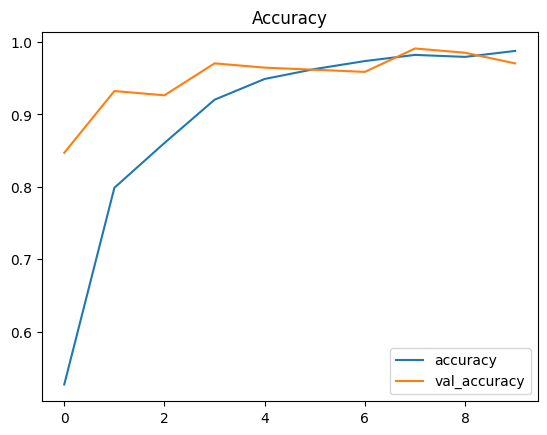

In [12]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

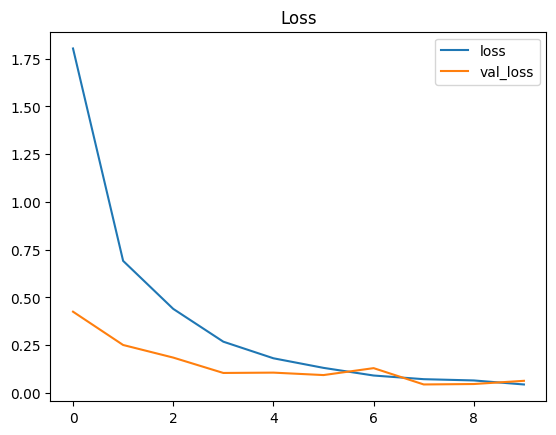

In [13]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

## 🍎 **Model Evaluation: Classification Report** 📊

The **classification report** assesses the model's ability to classify fruits and vegetables using these key metrics:

- **Precision**: Accuracy of positive predictions.  
- **Recall**: Ability to identify all relevant instances.  
- **F1-Score**: Balance between precision and recall.  
- **Support**: Number of true samples for each class.

By comparing predicted labels (`pred`) with true labels (`y_test`), the report evaluates performance across categories like apples, bananas, and tomatoes, highlighting strengths and areas for improvement.

In [14]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

C:\Users\midot\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


In [15]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 99.12%


## 🍎 **Confusion Matrix: Heatmap Visualization** 🔥

The confusion matrix breaks down the model's predictions for fruits and vegetables, showing:  

- **True Positives** (correct classifications) along the diagonal.  
- **False Positives** and **False Negatives** (misclassifications) off the diagonal.  
- **Color intensity** indicates prediction frequency, highlighting errors.

This heatmap offers a quick way to evaluate the model's strengths and areas for improvement across all categories.

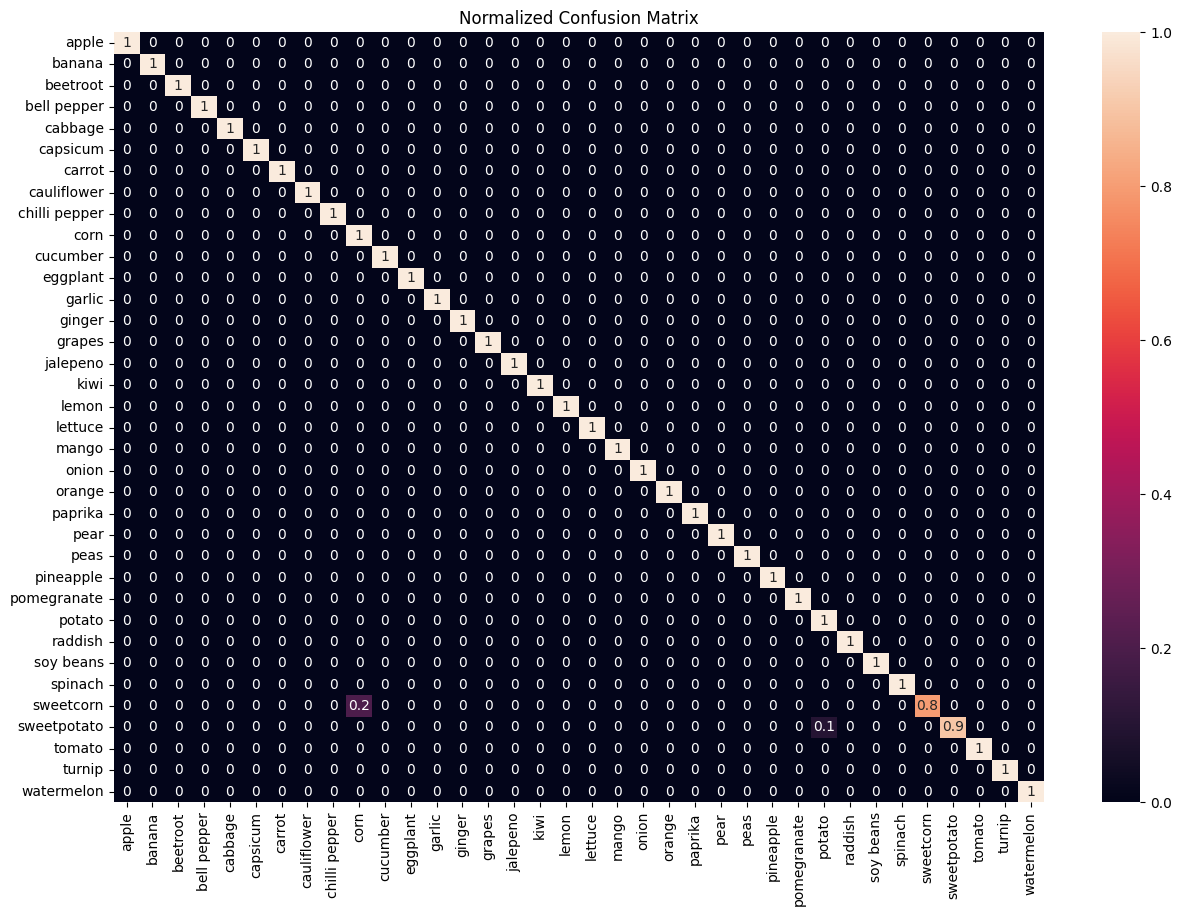

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

* Each row shows how the model’s predictions compare to the actual item.
* A high number (close to 1.0) on the diagonal means the model is almost always correct for that item.
* Most items are correctly identified, which shows the model is very accurate.
*Some similar items, like sweet potato and potato, may get confused because they look alike.
* Overall, the model does a good job, but it sometimes mixes up items with similar appearance if the quality isnt high enough.

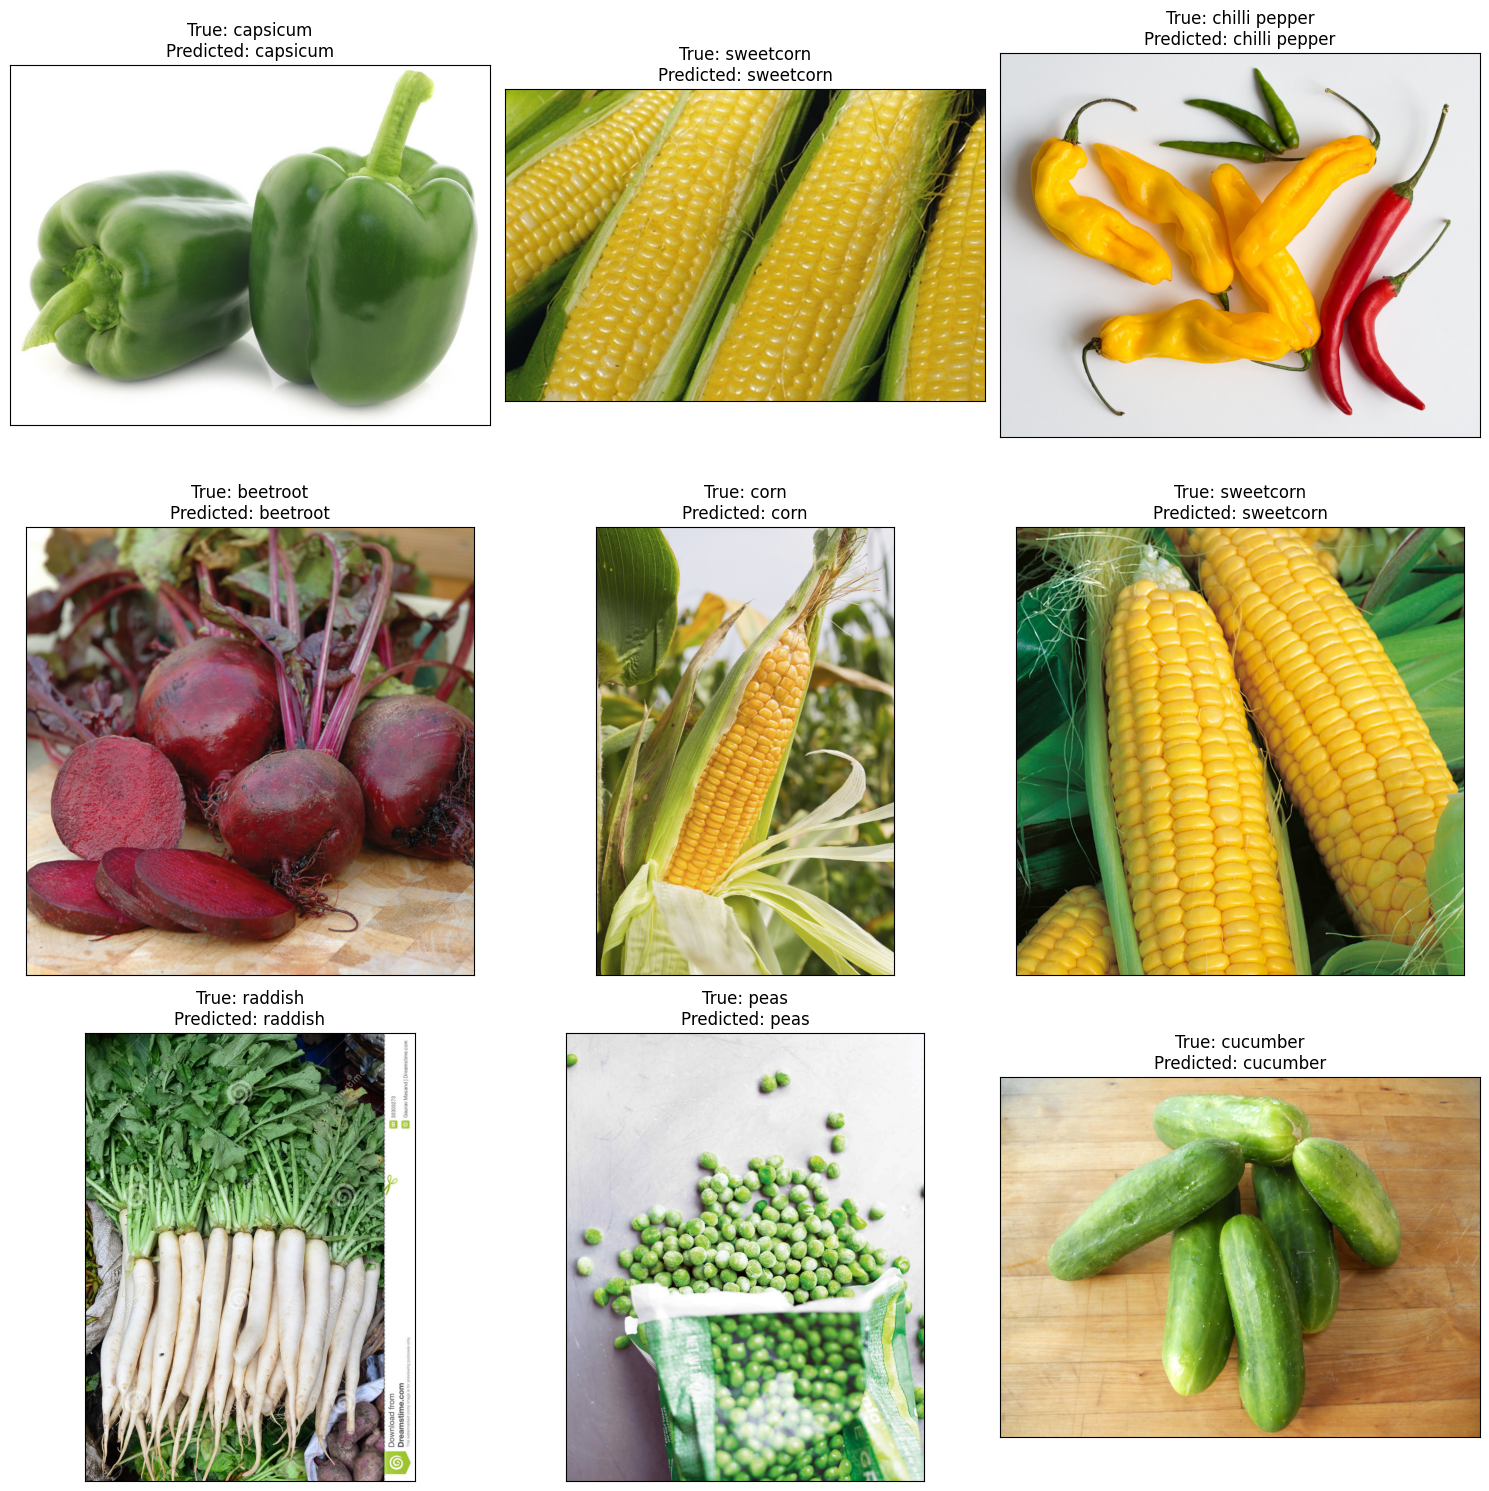

In [17]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [18]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\midot\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\midot\AppData\Local\Temp\ipykernel_25820\2731422595.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


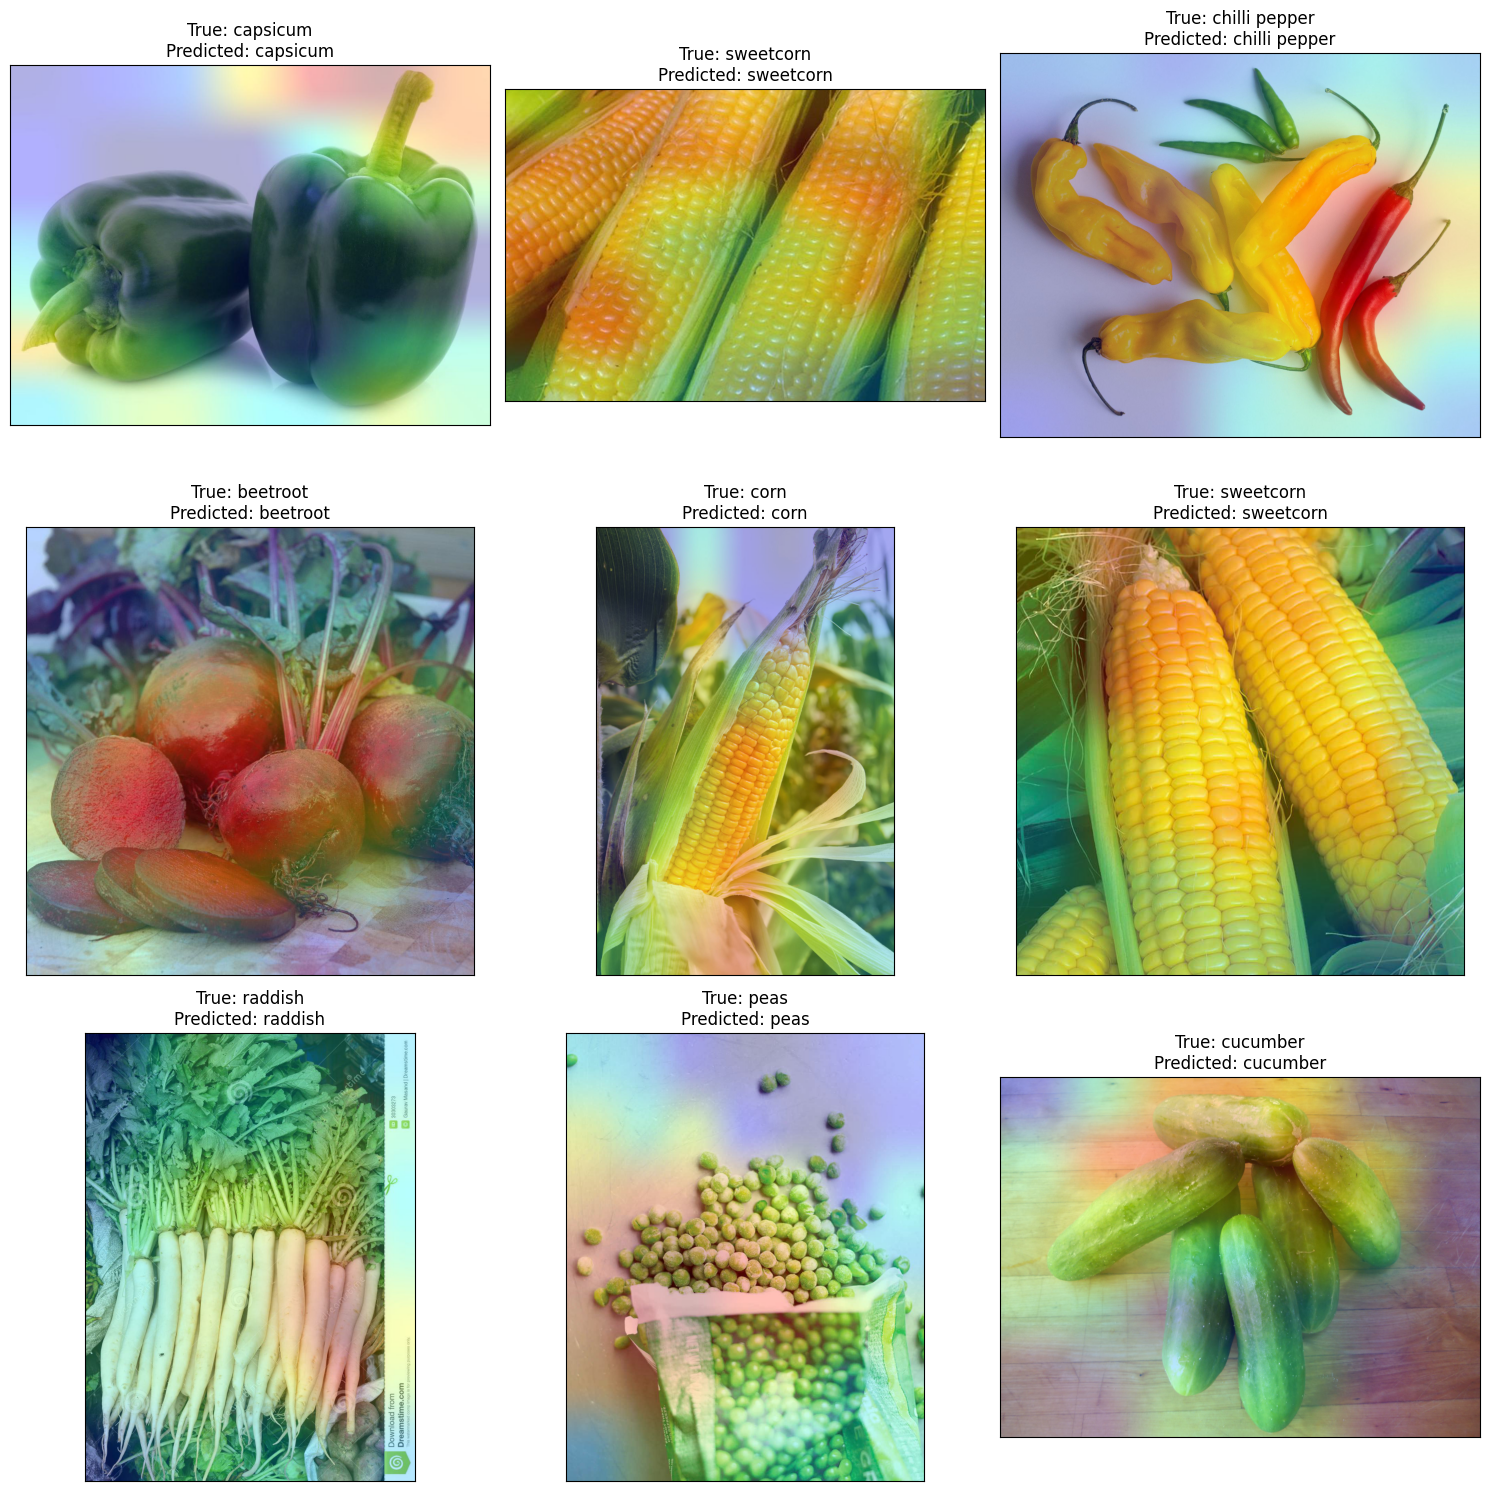

In [19]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()